<a href="https://colab.research.google.com/github/geraldoferreira1963/Analise_Sentimento/blob/main/Analise_Sentimento_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

O objetivo do trabalho é utilizando um dataset (https://www.kaggle.com/datasets/deepakjoshi2k/yahoo-stock-prediction-by-news) predizer se ação de uma dada empresa - no final de dia de negociação - subirá ou descera (tomando como base o dia anterior).


Este algoritmo, juntamente com outros algoritmos ou metodologias, por exemplo Análise Gráfica, poderiam ser combinados a fim de se criar um ferramenta de suporte a operação de compra e venda de ativos em um único dia na bolsa de valores.


No treinamento do algoritmo foi utilizado o dataset https://www.kaggle.com/datasets/deepakjoshi2k/yahoo-stock-prediction-by-news, o qual possui as seguintes colunas :   

(i)     **ticker** : código da ação na Bolsa de Valores de New York
(ii)    **Date** : Data da notícia ou opinião
(iii)   **Category** : se é uma notícia, ou uma opinião de um analista.
(iv)    **title** : título da notícia, ou do artigo
(v)     **content** : conteúdo da notícia, ou do artigo
(vi)    **Open** : valor de abertura da ação
(vii)   **High** : valor de fechamento da ação
(viii)  **Low** : menor valor da ação no dia
(ix)    **Close** : valor de fechamento do preço da ação
(x)     **Adj cloe** : Ajusted Closing Price, ajuste no preço da ação decorrente de algum evento na base acionária da empresa
(xi)    **Volume** : volume de ações negociadas no dia
(xii) **label** : indicação se o preço da ação fechou com um valor maior que o preço **inicial** (1), ou fechou em um valor menor (0)





In [38]:
!pip install scikit-learn -q
!pip install transformers -q



import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string
import time
import pickle
import warnings



from sklearn.exceptions import DataConversionWarning
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import TextVectorization
from sklearn.preprocessing import LabelEncoder  # Import LabelEncoder
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from IPython import get_ipython
from IPython.display import display,HTML
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from transformers import BertTokenizer, TFBertModel
from sklearn.exceptions import ConvergenceWarning

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

warnings.filterwarnings("ignore", category=DataConversionWarning)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


As funções abaixo foram criadas.

(1) dataframe_analize : objetivo é realizar uma simples
(2) b

In [2]:
def analisar_dataframe (df, column_name='title'):  # Add column_name parameter with default 'title'
    """Analyzes a DataFrame and prints statistics about labels, content, and category.

    Args:
        df: The DataFrame to analyze.
        column_name: The column to use for content analysis ('title' or 'content').
    """

    # Count and print label occurrences
    label_counts = df['label'].value_counts()
    print("Número de Linhas com Label 0:", label_counts[0])
    print("Número de Linhas com Label 1:", label_counts[1])

    # Plot label distribution
    label_counts.plot(kind='bar', title='Distribuição dos Labels')
    plt.xlabel('Label')
    plt.ylabel('Contagem')
    plt.show()

    # Calculate and print content length statistics
    df['text_length'] = df[column_name].apply(len)  # Use column_name instead of 'title'
    print("Minimo comprimento do conteúdo:", df['text_length'].min())  # Use 'text_length'
    print("Máximo comprimento do conteúdo:", df['text_length'].max())  # Use 'text_length'

    # Calculate and print the number of unique words
    all_words = ' '.join(df[column_name]).lower().split()  # Use column_name instead of 'title'
    unique_words = set(all_words)
    print("Numero de palavras únicas:", len(unique_words))

    # Combined category-label plot
    plt.figure(figsize=(12, 6))
    sns.countplot(x='category', hue='label', data=df)
    plt.title('Distribuição das Categorias/Label')
    plt.xlabel('Categoria')
    plt.ylabel('Contagem')
    plt.xticks(rotation=45, ha='right')
    plt.show()
    return(len(unique_words),df['text_length'].min(),df['text_length'].max())

In [3]:
def criar_dataframe_balanceado(df, num_instances):
  """Creates a balanced DataFrame with a specified number of instances for each label.

  Args:
    df: The original DataFrame.
    num_instances: The desired number of instances for each label.

  Returns:
    A new DataFrame with balanced labels.
  """

  # Separate instances with label 0 and label 1
  label_0_df = df[df['label'] == 0]
  label_1_df = df[df['label'] == 1]

  # Sample the desired number of instances from each label
  balanced_label_0_df = label_0_df.sample(n=num_instances, random_state=42)  # Use random_state for reproducibility
  balanced_label_1_df = label_1_df.sample(n=num_instances, random_state=42)

  # Concatenate the balanced DataFrames
  balanced_df = pd.concat([balanced_label_0_df, balanced_label_1_df])

  return balanced_df

In [4]:
def preprocess_text(text, lemmatize=True):
    """Removes stop words, punctuation, and optionally performs lemmatization.

    Args:
        text: The input text string.
        lemmatize: A boolean indicating whether to perform lemmatization.

    Returns:
        The preprocessed text string.
    """

    # Tokenize the text
    tokens = nltk.word_tokenize(text.lower())

    # Remove punctuation
    tokens = [token for token in tokens if token not in string.punctuation]

    # Remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # Lemmatize if specified
    if lemmatize:
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # Join the tokens back into a string
    preprocessed_text = ' '.join(tokens)

    return preprocessed_text

In [36]:
def treino (pipeline_name, pipeline, param_grid, X_train, y_train):
    """
    Trains a pipeline using GridSearchCV and measures the training time.

    Args:
        pipeline_name (str): The name of the pipeline (e.g., 'Logistic Regression').
        pipeline: The pipeline object to be trained.
        param_grid (dict): The parameter grid for GridSearchCV.
        X_train: The training data.
        y_train: The training labels.

    Returns:
        float: The training time in seconds.
    """
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=1)
    start_time = time.time()
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        grid_search.fit(X_train, y_train)
    end_time = time.time()
    training_time = end_time - start_time
    print(f"{pipeline_name} training time: {training_time:.2f} seconds")
    return training_time, grid_search.best_estimator_, grid_search


In [16]:
def plot_acuracia_por_max_features(logreg_grid_search_results, svm_grid_search_results):
    """Plots accuracy against the number of features/tokens for Logistic Regression and SVM.

    Args:
        logreg_grid_search_results: The cv_results_ attribute of the Logistic Regression GridSearchCV object.
        svm_grid_search_results: The cv_results_ attribute of the SVM GridSearchCV object.
    """
    logreg_results = pd.DataFrame(logreg_grid_search_results.cv_results_)
    logreg_accuracy_by_max_features = logreg_results.groupby('param_preprocessor__tfidf__max_features')['mean_test_score'].mean()

    svm_results = pd.DataFrame(svm_grid_search_results.cv_results_)
    svm_accuracy_by_max_features = svm_results.groupby('param_preprocessor__tfidf__max_features')['mean_test_score'].mean()

    plt.figure(figsize=(10, 6))
    plt.plot(logreg_accuracy_by_max_features.index, logreg_accuracy_by_max_features.values, marker='o', label='Logistic Regression')
    plt.plot(svm_accuracy_by_max_features.index, svm_accuracy_by_max_features.values, marker='x', label='SVM')
    plt.title('Acurácia por # Features/Tokens')
    plt.xlabel('# Features/Tokens')
    plt.ylabel('Acurácia')
    plt.legend()
    plt.grid(True)
    plt.show()

In [7]:
def avaliacao_e_plot_acuracia(y_test, logreg_bert_predictions, svm_bert_predictions):
    """Evaluates and reports the accuracy of Logistic Regression and SVM models.

    Args:
        y_test: The true labels for the test data.
        logreg_bert_predictions: The predictions from the Logistic Regression model.
        svm_bert_predictions: The predictions from the SVM model.
    """

    # Logistic Regression Evaluation
    logreg_bert_accuracy = accuracy_score(y_test, logreg_bert_predictions)
    print(f"Acurácia Logistic Regression (após otimização): {logreg_bert_accuracy}")
    print(classification_report(y_test, logreg_bert_predictions))

    # SVM Evaluation
    svm_bert_accuracy = accuracy_score(y_test, svm_bert_predictions)
    print(f"Acurácia SVM Accuracy (após otimização): {svm_bert_accuracy}")
    print(classification_report(y_test, svm_bert_predictions))

In [8]:
def impressao_tempo(training_time_seconds, model_name):
    """Prints the training time in hours, minutes, and seconds.

    Args:
        training_time_seconds: The training time in seconds.
        model_name: The name of the model being trained.
    """

    hours = int(training_time_seconds // 3600)
    minutes = int((training_time_seconds % 3600) // 60)
    seconds = int(training_time_seconds % 60)

    print(f"Tempo de Treinamento - {model_name}: {hours:02d}:{minutes:02d}:{seconds:02d}")

In [26]:
def display_best_hyperparameters(grid_search, model_name):
    """Displays the best hyperparameters and their scores in a table format.

    Args:
        grid_search_results: The cv_results_ attribute of the GridSearchCV object.
        model_name: The name of the model.
    """

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    table_html = f"<h3>{model_name} - Melhores Parametros e Score </h3>"
    table_html += "<table><tr><th>Hyperparameter</th><th>Value</th></tr>"
    for param, value in best_params.items():
        table_html += f"<tr><td>{param}</td><td>{value}</td></tr>"
    table_html += f"<tr><td><b>Best Score</b></td><td><b>{best_score:.4f}</b></td></tr></table>"

    display(HTML(table_html))


In [ ]:
l

In [17]:
def plot_confusion_matrices(y_test, logreg_predictions, svm_predictions):
    """Plots confusion matrices for Logistic Regression and SVM models.

    Args:
        y_test: The true labels for the test data.
        logreg_predictions: The predictions from the Logistic Regression model.
        svm_predictions: The predictions from the SVM model.
    """

    # Calculate confusion matrices
    logreg_cm = confusion_matrix(y_test, logreg_predictions)
    svm_cm = confusion_matrix(y_test, svm_predictions)

    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot Logistic Regression confusion matrix
    sns.heatmap(logreg_cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_title('Matrix Confusão - Regressão Logística')
    axes[0].set_xlabel('Predição')
    axes[0].set_ylabel('Real')

    # Plot SVM confusion matrix
    sns.heatmap(svm_cm, annot=True, fmt='d', cmap='Greens', ax=axes[1])
    axes[1].set_title('Matrix Confusão - SVM')  # Changed title to SVM
    axes[1].set_xlabel('Predição')
    axes[1].set_ylabel('Real')

    plt.show()  # Add plt.show() to display the plot

Gerar BERT embeddings

In [10]:
def get_bert_embeddings(text):
    inputs = tokenizer(text, return_tensors='tf', padding=True, truncation=True)
    outputs = model(inputs)
    embeddings = outputs.last_hidden_state[:, 0, :]  # Use the [CLS] token embedding
    return embeddings.numpy()



In [11]:
# Corrected URL to download the raw Excel file from GitHub
url = 'https://raw.githubusercontent.com/geraldoferreira1963/Analise_Sentimento/main/carga_inicial_6.xlsx'

response = requests.get(url)

# Save the content to a file with .xlsx extension
with open('carga_inicial_6.xlsx', 'wb') as file:
    file.write(response.content)

# Read the Excel file, explicitly specifying the engine
df = pd.read_excel('carga_inicial_6.xlsx', engine='openpyxl') # Added engine parameter

# Display the first few rows of the DataFrame
df.head()

,Date,category,title,content,label
0,2020-01-27,opinion,Apple Set To Beat Q1 Earnings Estimates Tech ...,Technology giant Apple NASDAQ AAPL is set ...,0
1,2020-01-27,opinion,Tech Daily Intel Results Netflix Surge Appl...,The top stories in this digest are Intel s N...,0
2,2020-01-27,opinion,7 Monster Stock Market Predictions For The Wee...,S P 500 SPY \nThis week will be packed with e...,0
3,2020-01-27,opinion,Apple Earnings Preview 5G Launch Expanding S...,Reports Q1 2020 results on Tuesday Jan 28 ...,0
4,2020-01-27,opinion,Buy Surging Apple Microsoft Stock Before Qua...,On today s episode of Full Court Finance here ...,0


Visualização Inicial do Dataset

Número de Linhas com Label 0: 7135
Número de Linhas com Label 1: 8840


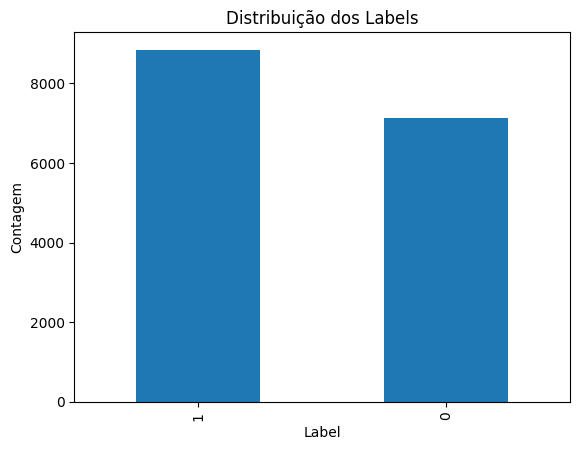

Minimo comprimento do conteúdo: 41
Máximo comprimento do conteúdo: 32765
Numero de palavras únicas: 85086


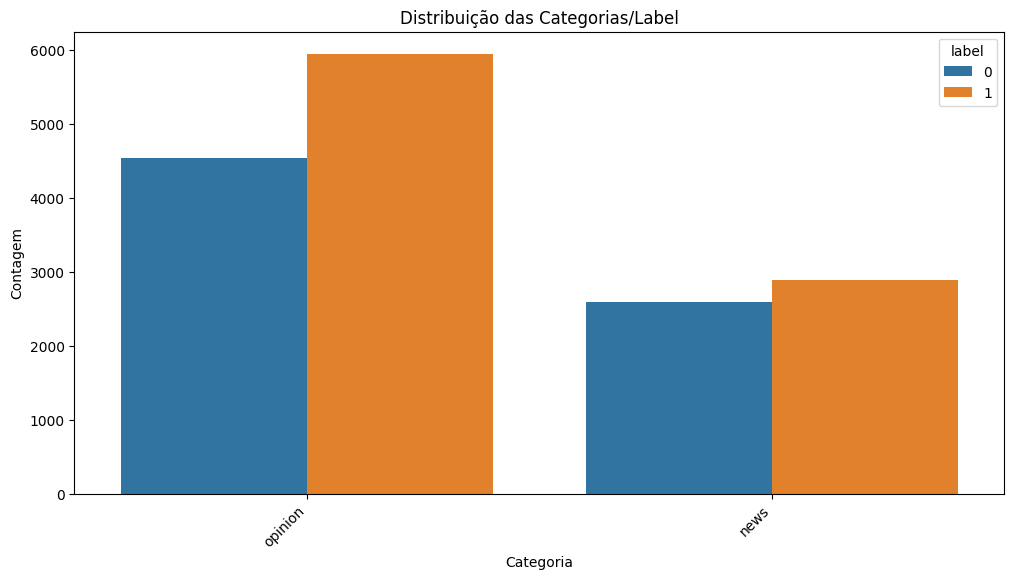

(85086, 41, 32765)

In [12]:

# Verificação Inicial do dataset
analisar_dataframe(df,column_name='content')  # Call the function to analyze your DataFrame


Ajuste Inicial

Número de Linhas com Label 0: 100
Número de Linhas com Label 1: 100


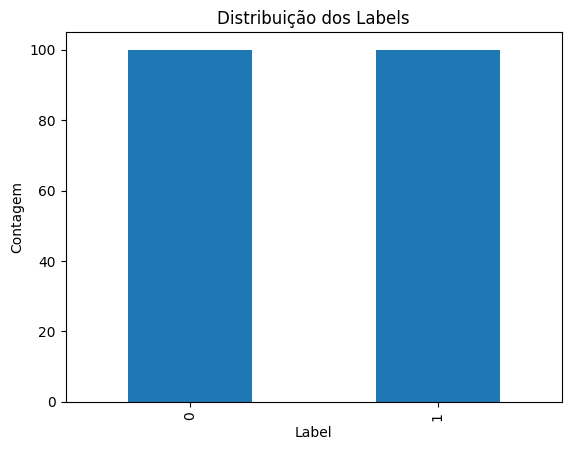

Minimo comprimento do conteúdo: 67
Máximo comprimento do conteúdo: 13304
Numero de palavras únicas: 10182


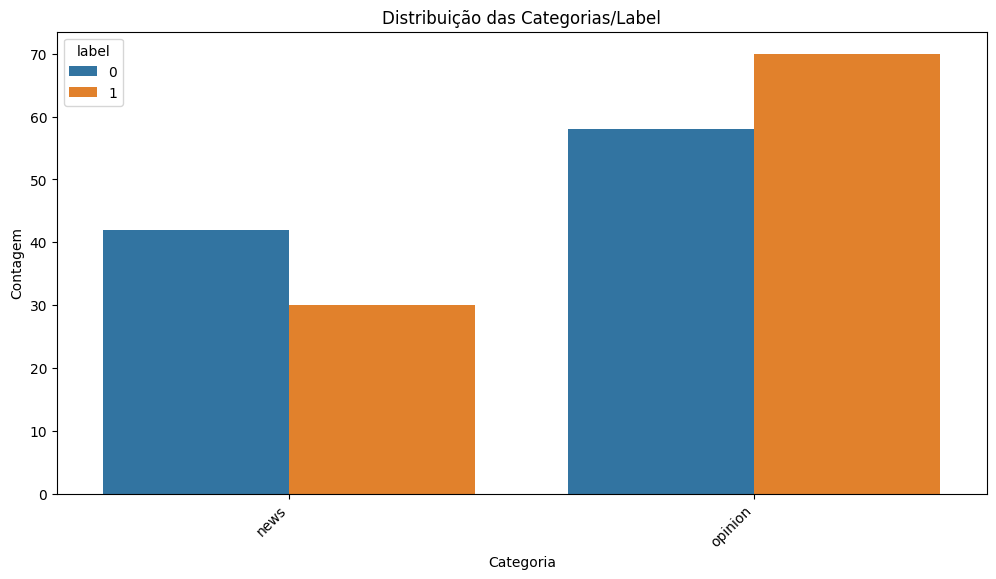

In [13]:
# Example usage:
num_instances_per_label = 1000  # Definir o número de instancias
balanced_df = criar_dataframe_balanceado(df, num_instances_per_label)
max_tokens,min_cont,max_cont = analisar_dataframe(balanced_df,column_name='content')

Preparação dos Dados

(1) Coluna News ou Opiniao
(2) Coluna Categoria
(3) Coluna label


In [14]:
print("Número de palavras únicas:", max_tokens)
print("Minimo comprimento do conteúdo:", min_cont)
print("Máximo comprimento do conteúdo:", max_cont)

Número de palavras únicas: 10182
Minimo comprimento do conteúdo: 67
Máximo comprimento do conteúdo: 13304


SVM e Regressão Logística - Preparação dos Dados

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Logistic Regression training time: 32.23 seconds
Fitting 5 folds for each of 36 candidates, totalling 180 fits
SVM training time: 27.24 seconds
Acurácia Logistic Regression (após otimização): 0.6
              precision    recall  f1-score   support

           0       0.65      0.52      0.58        21
           1       0.57      0.68      0.62        19

    accuracy                           0.60        40
   macro avg       0.61      0.60      0.60        40
weighted avg       0.61      0.60      0.60        40

Acurácia SVM Accuracy (após otimização): 0.575
              precision    recall  f1-score   support

           0       0.61      0.52      0.56        21
           1       0.55      0.63      0.59        19

    accuracy                           0.57        40
   macro avg       0.58      0.58      0.57        40
weighted avg       0.58      0.57      0.57        40



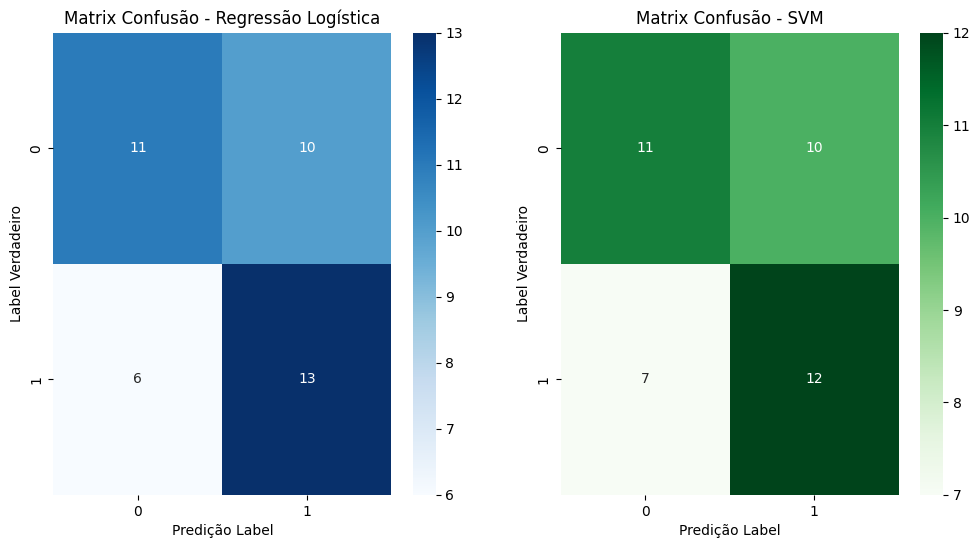

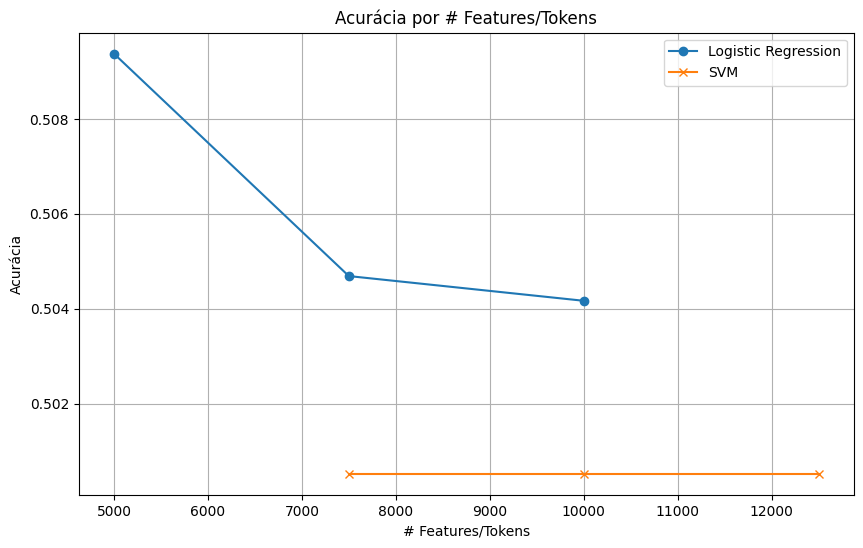

Hyperparameter,Value
logreg__C,0.1
logreg__penalty,l2
logreg__solver,liblinear
preprocessor__tfidf__max_features,5000
Best Score,0.5500


Hyperparameter,Value
preprocessor__tfidf__max_features,7500
svm__C,1
svm__gamma,scale
svm__kernel,rbf
Best Score,0.5563


Tempo de Treinamento - Regressão Logística: 00:00:32
Tempo de Treinamento - SVM: 00:00:27


In [39]:
#####  Pré Preparação dos Dados ################################################

# Remoção de Features

balanced_df['content'] = balanced_df['content'].apply(preprocess_text)

### Vetorização da coluna content e label encode da coluna categoria

def label_encode(X):
    le = LabelEncoder()
    encoded = le.fit_transform(X.values.ravel())
    return le.fit_transform(X).reshape(-1, 1)  # Reshape to 2D

preprocessor = ColumnTransformer(
    transformers=[
        ('tfidf', TfidfVectorizer(max_features=5000), 'content'),
        ('label_encoder', FunctionTransformer(label_encode, validate=False), ['category']),
    ],
    remainder='drop',  # Drop other columns
    verbose_feature_names_out=False

)

X = balanced_df[['content', 'category']]
y = balanced_df['label'].values.ravel()

######################### Criando os dados de Treinamento e Teste ##############

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


##### Pipelines Regressão Logística e  SVM ####################################

pipeline_logreg = Pipeline([
    ('preprocessor', preprocessor),
    ('logreg', LogisticRegression(max_iter=500)),
])

pipeline_svm = Pipeline([
    ('preprocessor', preprocessor),
    ('svm', SVC()),
])

########## Hipeparametros ########################################
# Regressão Logística
# max_features = Número de Tokens/Palavras a serem mantidas no Vetor TD-IDF om base na sua importância
# C = Controle da Regularização : Trade Off entre Bias X Variança e Complexidade do Modelo
# Penalty : L1 (lasso) e  L2 (ridge)
# Solver : Algoritmo a ser usado na otimização (LIBLINEAR ou SAGA). SAGA : Grande Dataset X LIBLINEAR : Otimizador Simples
# Kernel : linear :  Relações mais lineares X  RBF kernel: flexibilidade e relações não lineares.

logreg_param_grid = {
    'preprocessor__tfidf__max_features': [5000, 7500, 10000],
    'logreg__C': [0.1, 1, 10],
    'logreg__penalty': ['l1', 'l2'],
    'logreg__solver': ['liblinear', 'saga']
}

svm_param_grid = {
    'preprocessor__tfidf__max_features': [7500, 10000, 12500],
    'svm__C': [0.1, 1, 10],
    'svm__kernel': ['linear', 'rbf'],
    'svm__gamma': ['scale', 'auto']
}


############################## Treinamento #####################################

# Regressão Logistica

logreg_training_time,logreg_best_model, logreg_grid_search= treino(
    'Logistic Regression', pipeline_logreg, logreg_param_grid, X_train, y_train
)

# SVM

svm_training_time,svm_best_model, svm_grid_search = treino(
    'SVM', pipeline_svm, svm_param_grid, X_train, y_train
)



############### Teste #########################################################

logreg_predictions = logreg_best_model.predict(X_test)
svm_predictions = svm_best_model.predict(X_test)


############## Resultado ######################################################

# Geral

avaliacao_e_plot_acuracia(y_test, logreg_predictions, svm_predictions)

# Matriz Confusão

plot_confusion_matrices(y_test, logreg_predictions, svm_predictions)

# Acurácia X Max Features

plot_acuracia_por_max_features(logreg_grid_search_results, svm_grid_search_results)


# Impressão Melhores Hipe-Parametros
display_best_hyperparameters(logreg_grid_search, "Regressão Logística")
display_best_hyperparameters(svm_grid_search, "SVM")


# Tempos de Treinamento

impressao_tempo(logreg_training_time, "Regressão Logística")
impressao_tempo(svm_training_time, "SVM")



Substituindo TD-IDF por BERT

Tempo de Simulação : (1) Regressão Logística =   (2) SVM =

Acurácia Logistic Regression (após otimização): 0.425
              precision    recall  f1-score   support

           0       0.46      0.57      0.51        21
           1       0.36      0.26      0.30        19

    accuracy                           0.42        40
   macro avg       0.41      0.42      0.41        40
weighted avg       0.41      0.42      0.41        40

Acurácia SVM Accuracy (após otimização): 0.525
              precision    recall  f1-score   support

           0       0.54      0.62      0.58        21
           1       0.50      0.42      0.46        19

    accuracy                           0.53        40
   macro avg       0.52      0.52      0.52        40
weighted avg       0.52      0.53      0.52        40



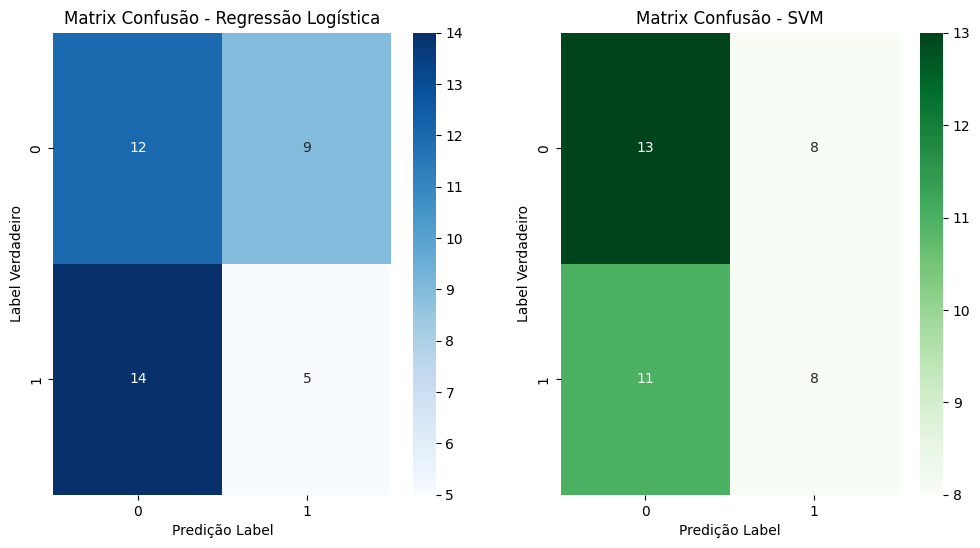

Hyperparameter,Value
logreg__C,10
logreg__penalty,l1
logreg__solver,liblinear
Best Score,0.5625


Hyperparameter,Value
svm__C,1
svm__gamma,scale
svm__kernel,linear
Best Score,0.5437


Tempo de Treinamento - Regressão Logística: 00:00:48
Tempo de Treinamento - SVM: 00:00:00


In [44]:
############# Carregando token e modelo BERT treinado#########################

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertModel.from_pretrained('bert-base-uncased')

# ############### Preparando Dados ############################################

balanced_df['content'] = balanced_df['content'].apply(preprocess_text)

# Verificando se já existe BERT embeddings

try:
    with open('bert_embeddings.pkl', 'rb') as f:
        balanced_df['embeddings'] = pickle.load(f)
    print("Loaded BERT embeddings from file.")
except FileNotFoundError:
    print("Embeddings file not found, recalculating...")
    balanced_df['embeddings'] = balanced_df['content'].apply(get_bert_embeddings)
    # Gerando BERT embeddings
    with open('bert_embeddings.pkl', 'wb') as f:
        pickle.dump(balanced_df['embeddings'], f)


X_embeddings = np.array(balanced_df['embeddings'].tolist())
# Reshape X_embeddings para  2D
X_embeddings = X_embeddings.reshape(X_embeddings.shape[0], X_embeddings.shape[2])

# Label encode da coluna category
label_encoder = LabelEncoder()
X_category_encoded = label_encoder.fit_transform(balanced_df['category']) # Fit and transform the category column
X_category_encoded = X_category_encoded.reshape(-1, 1) # Reshape to 2D

# Merge embeddings com  encoded category
X = np.concatenate([X_embeddings, X_category_encoded], axis=1)
y = balanced_df['label'].values.ravel()



############### Atualizando os preprocessador e os pipelines####################

# pipelines
pipeline_logreg = Pipeline([
    ('logreg', LogisticRegression(max_iter=500)),
])

pipeline_svm = Pipeline([
    ('svm', SVC()),
])

# Atualizandos os Grids

logreg_param_grid = {
    'logreg__C': [0.1, 1, 10],
    'logreg__penalty': ['l1', 'l2'],
    'logreg__solver': ['liblinear', 'saga']
}

svm_param_grid = {
    'svm__C': [0.1, 1, 10],
    'svm__kernel': ['linear', 'rbf'],
    'svm__gamma': ['scale', 'auto']
}


######################### Criando os dados de Treinamento e Teste ##############

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


############################## Treinamento #####################################

# Regressão Logistica

logreg_bert_training_time,logreg_bert_best_model, logreg_bert_grid_search= treino(
    'Logistic Regression', pipeline_logreg, logreg_param_grid, X_train, y_train
)

# SVM

svm_bert_training_time,svm_bert_best_model, svm_bert_grid_search = treino(
    'SVM', pipeline_svm, svm_param_grid, X_train, y_train
)


############### Teste #########################################################

logreg_bert_predictions = logreg_bert_best_model.predict(X_test)
svm_bert_predictions = svm_bert_best_model.predict(X_test)


############## Resultado ######################################################

# Geral

avaliacao_e_plot_acuracia(y_test, logreg_bert_predictions, svm_bert_predictions)

# Matriz Confusão

plot_confusion_matrices(y_test, logreg_bert_predictions, svm_bert_predictions)


# Impressão Melhores Hipe-Parametros
display_best_hyperparameters(logreg_bert_grid_search, "Regressão Logística")
display_best_hyperparameters(svm_bert_grid_search, "SVM")

# Tempos de Treinamento

impressao_tempo(logreg_bert_training_time, "Regressão Logística")
impressao_tempo(svm_bert_training_time, "SVM")

